In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [14]:
file_path = "./train-sales.csv"
df_original = pd.read_csv(file_path, parse_dates=["date"])
df_original.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [15]:
df = df_original.copy(deep=True)
df_original.shape


(913000, 4)

In [16]:
df.isnull().sum(axis=0)

date     0
store    0
item     0
sales    0
dtype: int64

    There are no null cells

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


    All dtypes are appropriate

    Since we are building model irrespective of the store we can drop that column

In [18]:
df.drop("store", axis=1, inplace=True)


In [19]:
df.describe()

,item,sales
count,913000.000000,913000.000000
mean,25.500000,52.250287
std,14.430878,28.801144
min,1.000000,0.000000
25%,13.000000,30.000000
50%,25.500000,47.000000
75%,38.000000,70.000000
max,50.000000,231.000000


In [20]:
df["date"].min(),df["date"].max(),

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

    Sum all the sales of items on same date

In [21]:
df = df.groupby(["date","item"]).sum().reset_index()
df.describe()

,item,sales
count,91300.000000,91300.000000
mean,25.500000,522.502870
std,14.430949,255.234706
min,1.000000,71.000000
25%,13.000000,310.000000
50%,25.500000,489.000000
75%,38.000000,695.000000
max,50.000000,1573.000000


    The count reduced from 9,13,000 to 91,300 because or our aggregation

    Let us set date as the index since we are going to time based EDA

In [22]:
df.set_index("date",inplace=True)
df.head()

,item,sales
date,,
2013-01-01,1,133
2013-01-01,2,327
2013-01-01,3,172
2013-01-01,4,102
2013-01-01,5,83


In [23]:
corr_df = df.pivot_table(values='sales', index=df.index, columns='item').corr()


<AxesSubplot:xlabel='item', ylabel='item'>

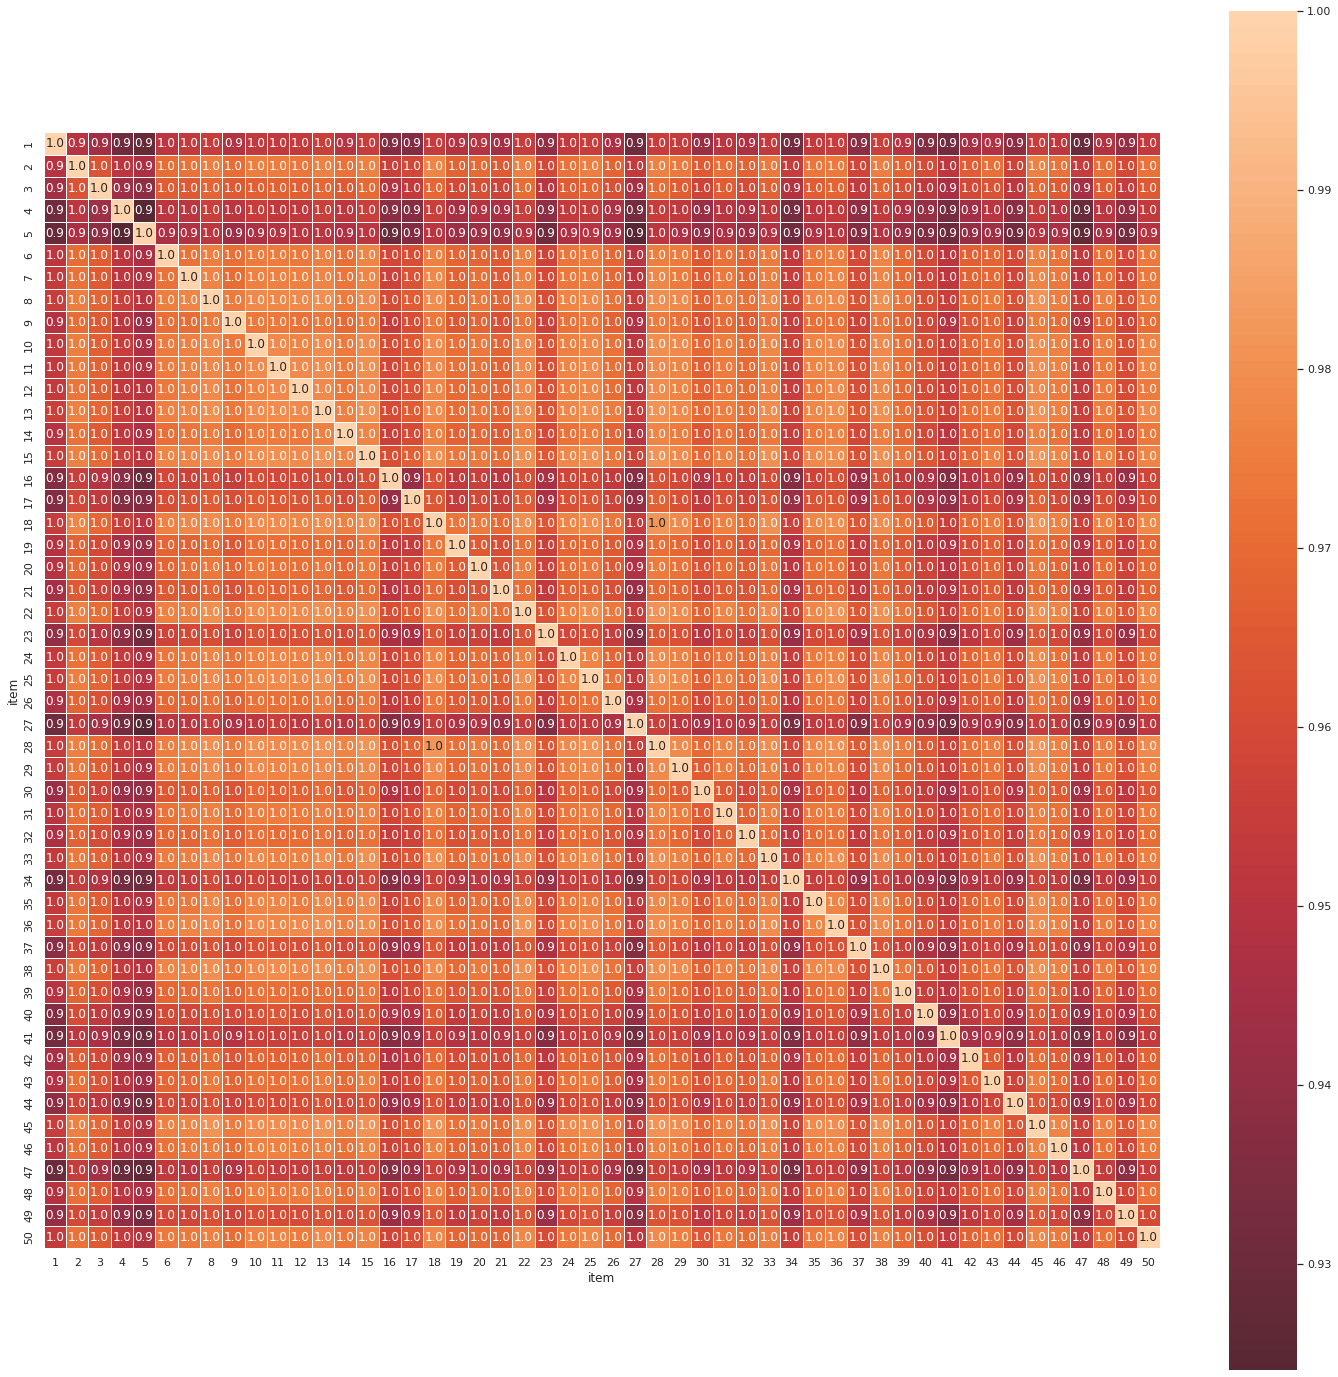

In [24]:
sns.set(rc={'figure.figsize': (25, 25)})

sns.heatmap(data=corr_df, square=True,
            annot=True, fmt='.1f', linewidths=1, center=0.9)


In [25]:
corr_df.min().min()

0.9240918942073008

    We find that the lowest linear corelation between sales for different products is greater than 0.92 . This means that all  almost always follows the same sale pattern along the timeline, but there can be a magnitude difference but the pattern is same . We can demonstrate this by plotting the lowest correlation pair we discovered

In [26]:
corr_df[corr_df == corr_df.min().min()].dropna(how='all').dropna(axis=1)

item
item
5
27


    The lowest corelation is between 5 and 27 which corresponds to 0.924

<AxesSubplot:xlabel='date'>

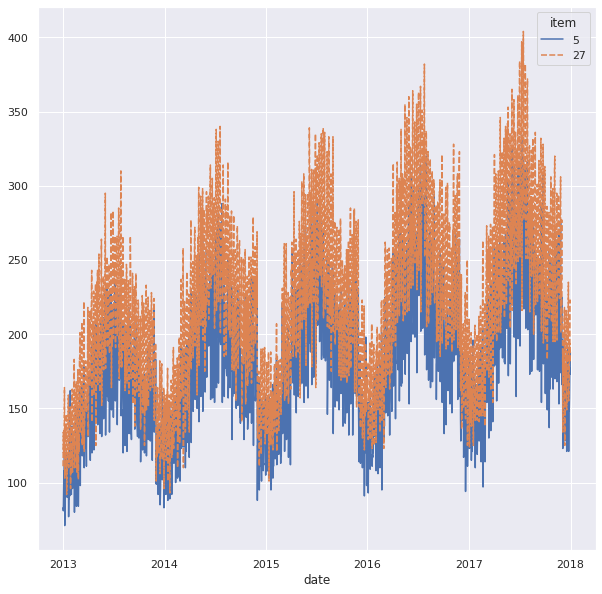

In [27]:
plot_df = df.pivot_table(values='sales', index=df.index, columns='item')[[5,27]]
sns.set(rc={'figure.figsize': (10, 10)})
sns.lineplot(data = plot_df)

    Scaling to remove the outliers and better understand correlation

In [28]:
from sklearn.preprocessing import StandardScaler

max_id = df['item'].unique().max()
# scalar_data = np.zeros(max_id+1)
scalar_data = list(range(max_id+1))
normalized_df = df.copy(deep=True)

for item in normalized_df['item'].unique().tolist():
    mask = normalized_df['item'] == item
    scalar = StandardScaler()
    normalized_df.loc[mask, 'sales'] = scalar.fit_transform(
        np.array(normalized_df.loc[mask, 'sales']).reshape(-1,1))
    scalar_data[item] = scalar.inverse_transform


In [29]:
normalized_df.head()

,item,sales
date,,
2013-01-01,1,-1.540113
2013-01-01,2,-1.788801
2013-01-01,3,-2.113760
2013-01-01,4,-2.113565
2013-01-01,5,-2.120857


<AxesSubplot:xlabel='date'>

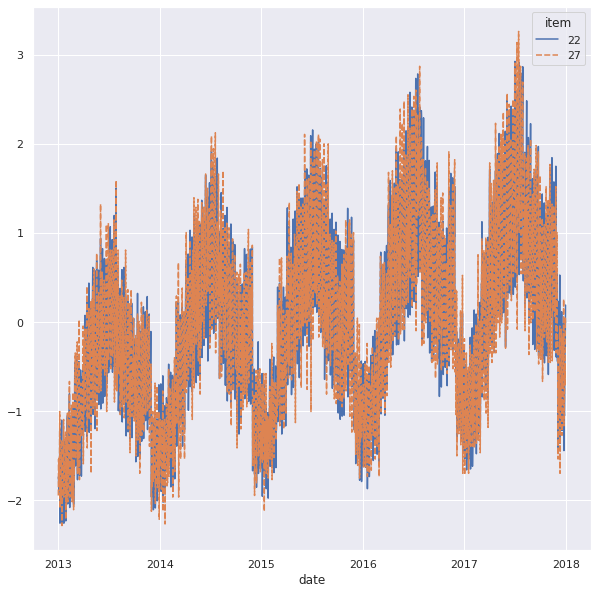

In [30]:
plot_df = normalized_df.pivot_table(
    values='sales', index=normalized_df.index, columns='item')[[22, 27]]
sns.set(rc={'figure.figsize': (10, 10)})
sns.lineplot(data=plot_df)


    Remove 2013 because it will affect the regression

In [31]:
mask = normalized_df.index.year == 2013
normalized_df = normalized_df[~mask]
normalized_df.head(3)

,item,sales
date,,
2014-01-01,1,-1.965872
2014-01-01,2,-1.470781
2014-01-01,3,-1.526672


    Outlier Detection

In [32]:
def outlier(series: pd.Series, sd=3, return_mask=False):
    z_score = (series-series.mean())/series.std()
    outliers_mask = np.abs(z_score) > sd
    if return_mask:
        return outliers_mask
    return series[outliers_mask]


In [33]:
result_sr = outlier(normalized_df['sales'],3, True)
print(result_sr.sum())
normalized_df[result_sr].head()

44


,item,sales
date,,
2016-07-03,21,3.377180
2016-07-03,31,3.145087
2016-07-03,33,3.231960
2016-07-03,47,3.198258
2016-07-17,16,3.266536


In [34]:
def clean_outliers(df: pd.DataFrame, sd=3, columns=None):
    df_ = df.copy(deep=True)
    if not columns:
        columns = df_.columns
    for column in columns:
        mask = outlier(df_[column], sd, True)
        df_ = df_[~mask]
    return df_


In [35]:
cleaned_df = clean_outliers(normalized_df, 3, ['sales'])
print(cleaned_df.shape)
cleaned_df.head(3)

(73006, 2)


,item,sales
date,,
2014-01-01,1,-1.965872
2014-01-01,2,-1.470781
2014-01-01,3,-1.526672


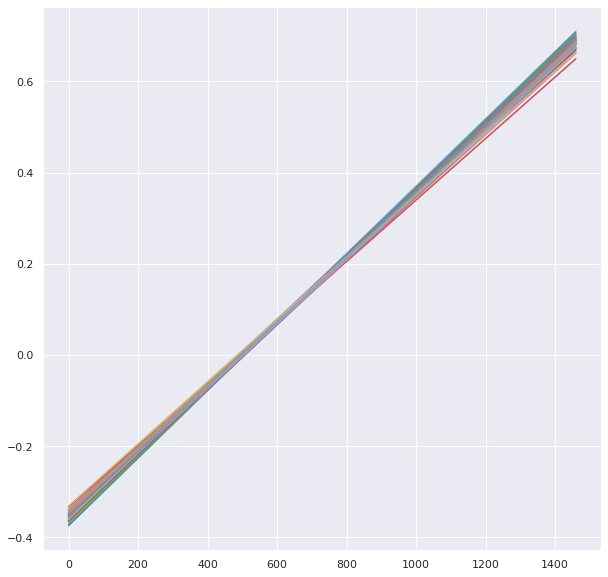

In [36]:
items = cleaned_df['item'].unique().tolist()
pivot_date = cleaned_df.index.min()
regression_test_df = cleaned_df
regression_test_df["date_id"] = (regression_test_df.index-pivot_date).days
for item in items:
    reg_df = regression_test_df[regression_test_df['item'] == item]
    reg_poly_coeffs = np.polyfit(reg_df["date_id"], reg_df["sales"], 1)
    reg_poly = np.poly1d(reg_poly_coeffs)
    pts_x = [reg_df["date_id"][0], reg_df["date_id"][-1]]
    pts_y = reg_poly(pts_x)
    sns.lineplot(x=pts_x, y=pts_y)


    Even though we saw from our initial hypothesis with corelation matrix that every item is having almost same trend its is clear from the above plot that  items are not in parallel hence we will need to create different sub models of our hybrid model

    From this Information we can go forward and create a `Hybrid` model

###  Steps for Hybrid model
-   Find liner regression of each item
-   Remove the trend by subtracting the liner regression
-   item wise de-trended data by mean and fit a Fourier for Larger than 2 weeks patterns and a polynomial fit for lesser than 2 weeks .
-   Remove the seasonality from above step
-   We will then add features ``[dayofweek, dayofmonth, dayofyear, isweekend, week, month, quarter]`` to help our final model to learn the residuals like weekends, holidays, etc.
-   Finally we will put all 4 of our models together to form our hybrid model

    Even though we will be creating item wise model for regression, fourier, and polynomial; Our final ensemble model will be able to accommodate single model for all items . So for demonstration purpose we will only run/plot 1 item for first 3 models and then run without plot for all other items, and finally train the residual on ensemble model. Since we are running separate models we can invert our scaling

In [37]:
def de_scale(df_: pd.DataFrame):
    items = df_['item'].unique().tolist()
    df_.reset_index(inplace=True, level='date')
    for item in items:
        mask = df_['item'] == item
        scalar_function = scalar_data[item]
        to_scale = np.array(df_.loc[mask, 'sales']).reshape(-1,1)
        df_.loc[mask, 'sales'] = scalar_function(to_scale)
    df_.set_index('date', inplace=True)
    return df_


In [38]:
df = de_scale(cleaned_df)
df.head(3)

,item,sales,date_id
date,,,
2014-01-01,1,109.0,0
2014-01-01,2,373.0,0
2014-01-01,3,226.0,0


    We will keep one item in our df demonstration of the separate models

In [39]:
df_all_items = df.copy(True)
df = df[df['item'] == 1].drop("item", axis=1)

<AxesSubplot:xlabel='date_id', ylabel='sales'>

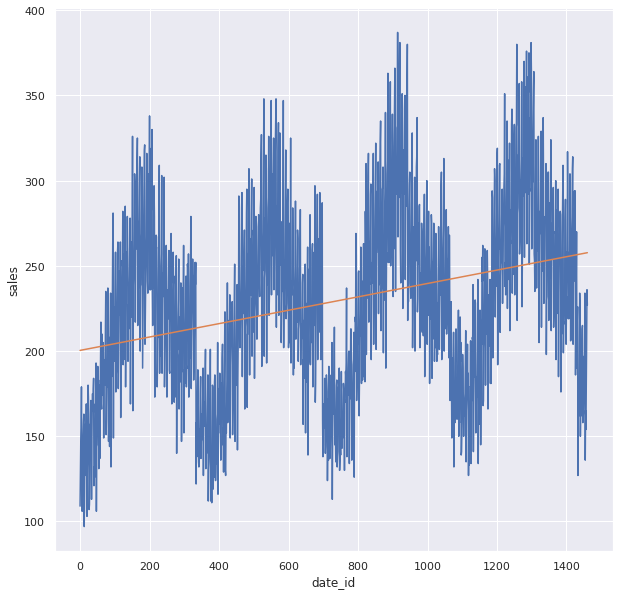

In [40]:
reg_poly_coeffs = np.polyfit(df["date_id"], df["sales"], 1)
reg_poly = np.poly1d(reg_poly_coeffs)
pts_x = [df["date_id"][0], df["date_id"][-1]]
pts_y = reg_poly(pts_x)
sns.lineplot(data=df, x="date_id", y="sales")
sns.lineplot(x= pts_x, y= pts_y)

    To remove trend subtract regression line from values

<AxesSubplot:xlabel='date', ylabel='sales'>

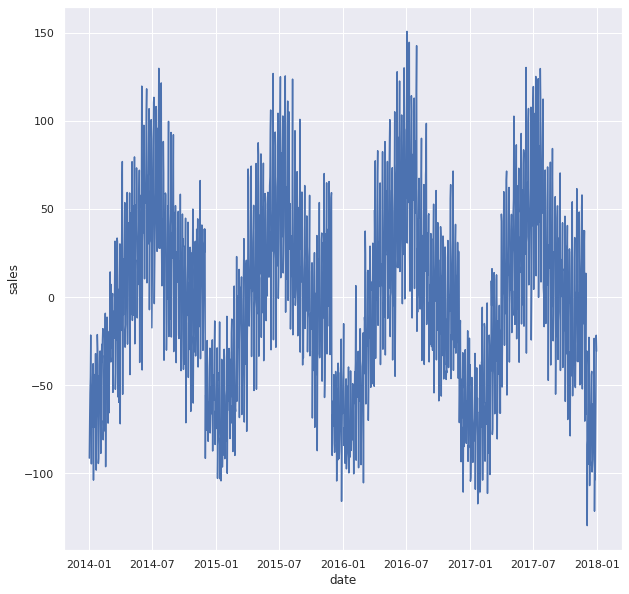

In [41]:
df["sales"] = df["sales"] - reg_poly(df['date_id']).flatten()
sns.lineplot(data=df['sales'])


    Next we can run a fft to get the frequency spectrum

<AxesSubplot:>

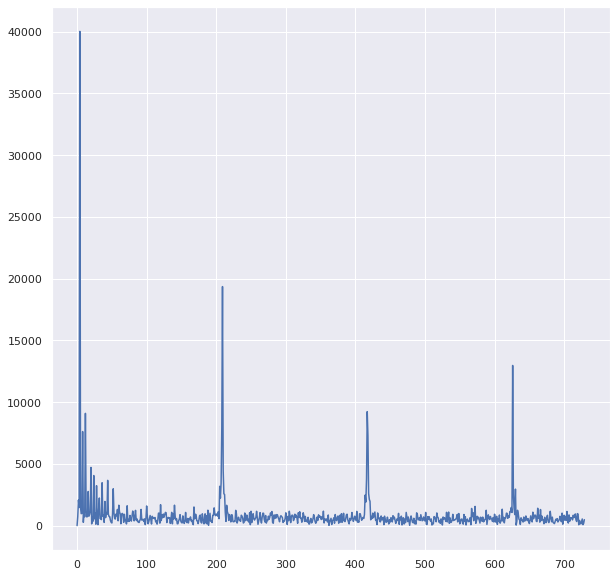

In [42]:
fft_out = np.fft.fft(df["sales"])
magnitudes = np.abs(fft_out)[:len(fft_out)//2]
sns.lineplot(data=magnitudes) 
# divided by 2 to avoid frequencies above Nyquist limit

    Get the predominant frequencies, I have selected n by trial and error

In [43]:
n = 25
frequencies = np.argpartition(magnitudes, -1*n)[-1*n:]
frequencies , magnitudes[frequencies]


(array([414, 627, 212, 211, 419,  16,  28, 207, 416,  36,  44, 630,  52,
        205,  24, 210,   8, 209, 208, 417,   4, 418, 626,  20,  12]),
 array([ 2469.14128372,  2565.21702843,  2519.67930038,  2572.45824328,
         2613.04431028,  2759.74581055,  3232.68358773,  3433.45441722,
         3784.78854112,  3468.48304027,  3662.62459212,  2953.23874237,
         2980.27654675,  3182.44817469,  4052.73947379,  4436.8640579 ,
         7613.55300218, 19350.80970602,  7931.96457902,  9226.39435979,
        40010.92382253,  7287.25026471, 12964.84075612,  4708.38612776,
         9087.01562557]))

    Select only greater than 1 month

In [44]:
frequency_in_days =len(magnitudes)*2/frequencies
frequency_in_days

array([  3.52657005,   2.32854864,   6.88679245,   6.91943128,
         3.48448687,  91.25      ,  52.14285714,   7.0531401 ,
         3.50961538,  40.55555556,  33.18181818,   2.31746032,
        28.07692308,   7.12195122,  60.83333333,   6.95238095,
       182.5       ,   6.98564593,   7.01923077,   3.50119904,
       365.        ,   3.49282297,   2.33226837,  73.        ,
       121.66666667])

In [45]:
def filter_fequency(fq):
    if fq == 0:
        return False
    fq_d = len(magnitudes)*2/fq
    return fq_d > 15


frequencies = np.array(list(filter(filter_fequency, frequencies)))
frequencies, len(magnitudes)*2/frequencies


(array([16, 28, 36, 44, 52, 24,  8,  4, 20, 12]),
 array([ 91.25      ,  52.14285714,  40.55555556,  33.18181818,
         28.07692308,  60.83333333, 182.5       , 365.        ,
         73.        , 121.66666667]))

    The above output shows us the day frequency of the cycles

    Reconstruct amplitude and phase-shift

In [46]:
complex_form = fft_out[frequencies]
amp = magnitudes[frequencies]/len(magnitudes)
ph = np.angle(complex_form)
data = {"amplitude":amp,"phase":ph}
signals = pd.DataFrame(data=data, index=frequencies)
signals

,amplitude,phase
16,3.780474,-2.121803
28,4.428334,-0.350027
36,4.751347,0.587125
44,5.017294,0.433573
52,4.082571,-3.028946
24,5.551698,-1.226592
8,10.429525,1.742502
4,54.809485,3.028147
20,6.449844,-2.702830
12,12.447967,2.556656


    Check if we can reconstruct the seasonality from the cos waves

In [47]:
def make_signal(fq=1, Ts=1, sf=500, ph=0, amp=1, type=np.sin):
    total_length = 2*np.pi*fq*Ts
    signal = np.linspace(0, total_length, sf, endpoint=True)
    time = np.linspace(0, Ts, sf, endpoint=True)
    signal_wave = amp*type(signal+ph)
    return pd.Series(signal_wave, index=time)

In [48]:
total_fq = pd.DataFrame()
for fq in signals.index:
    amp,ph = signals.loc[fq][["amplitude","phase"]].values
    fq_df = make_signal(fq,ph=ph,amp=amp, sf=len(df),type=np.cos)
    total_fq[f'{fq}'] = fq_df

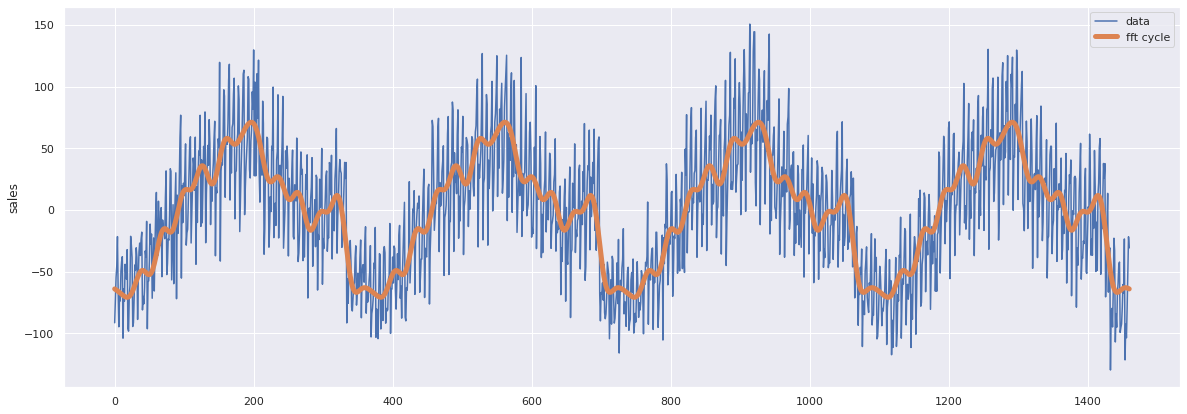

In [49]:
sum_frequency = total_fq.sum(axis=1)
sns.set(rc={'figure.figsize': (20, 7)})
sns.lineplot(y=df['sales'], x=list(range(len(df))), label='data')
sns.lineplot(y=sum_frequency.values, x=list(range(len(df))), linewidth = 5, label='fft cycle')
plt.legend()

    Subtract the seasonality

<AxesSubplot:xlabel='date', ylabel='sales'>

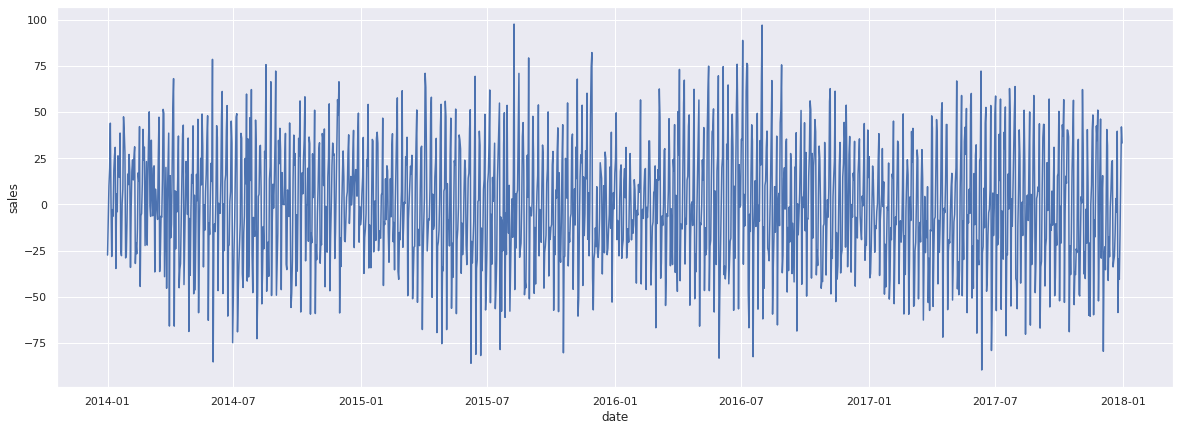

In [38]:
df['sales'] = df['sales']-sum_frequency.values 
sns.lineplot(data=df['sales'])

    We have to remove the seasonality that occurs weekly

    We can fit a polynomial and subtract it with respect to the day number

In [39]:
df["day_of_week"] = df.index.day_of_week
df.head()

,sales,date_id,day_of_week
date,,,
2014-01-01,-27.447938,0,2
2014-01-02,-8.130855,1,3
2014-01-03,10.214836,2,4
2014-01-04,19.582386,3,5
2014-01-05,43.966689,4,6


<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

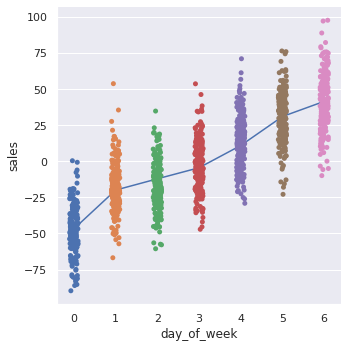

In [40]:
poly_coeffs = np.polyfit(df['day_of_week'],df['sales'], 4)
poly = np.poly1d(poly_coeffs)
points = poly(np.arange(7))
sns.catplot(x='day_of_week',y='sales', data=df)
sns.lineplot(data=points)

    Hence we can subtract the weekly trend

<AxesSubplot:xlabel='date', ylabel='sales'>

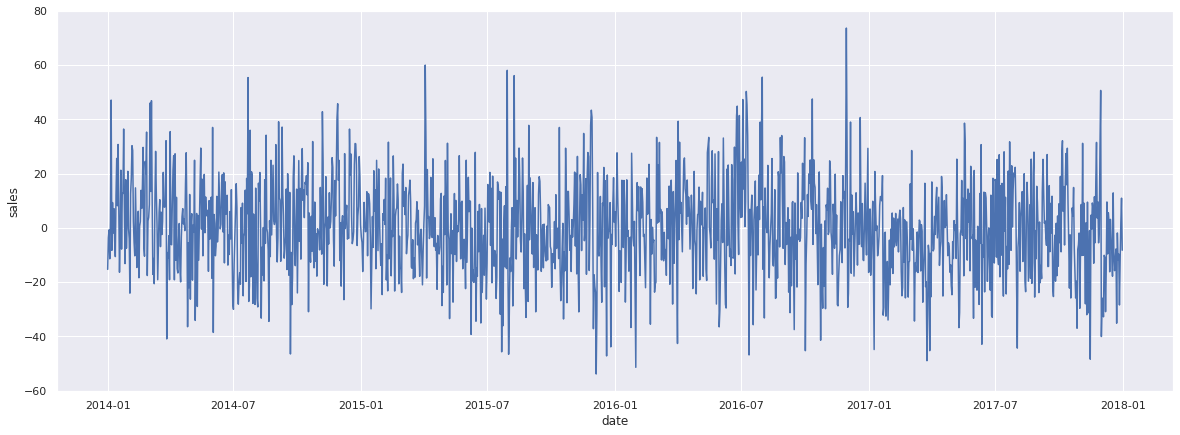

In [41]:
df['sales'] = df['sales'] - poly(df['day_of_week'])
sns.lineplot(data=df['sales'])

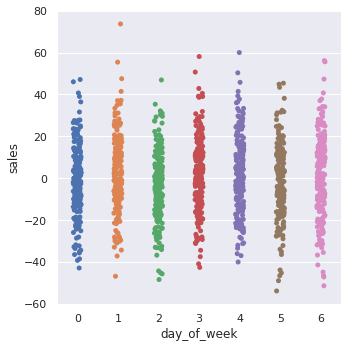

In [42]:
sns.catplot(x='day_of_week',y='sales', data=df)

    Checking if we removed predominant seasonality

<AxesSubplot:>

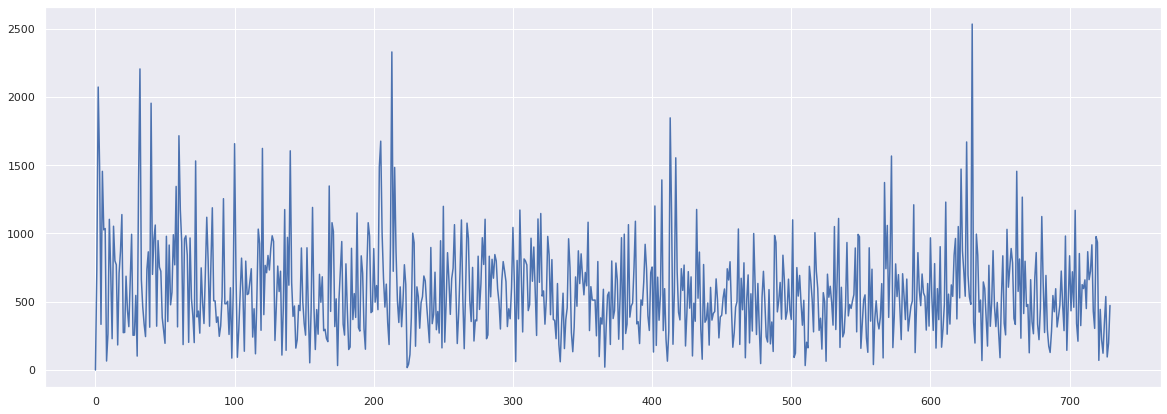

In [43]:
fft_out = np.fft.fft(df['sales'])
magnitudes = np.abs(fft_out)[:len(fft_out)//2]
sns.lineplot(data=magnitudes) 

    Running 3 models on all items

In [44]:
df = df_all_items

    Regression

In [45]:
items = df['item'].unique().tolist()
pivot_date = df.index.min()
reg_models = list(range(max_id+1))
for item in items:
    reg_df = df[df['item'] == item]
    reg_poly_coeffs = np.polyfit(reg_df["date_id"], reg_df["sales"], 1)
    reg_poly = np.poly1d(reg_poly_coeffs)
    pts_x = [reg_df["date_id"][0], reg_df["date_id"][-1]]
    pts_y = reg_poly(pts_x)
    reg_models[item] = reg_poly

    #detrending
    mask = df['item'] == item
    regressed_vals = reg_models[item](df.loc[mask, "date_id"])
    df.loc[mask, "sales"] = df.loc[mask, "sales"] - regressed_vals

    Fourier

In [46]:
fft_models = np.zeros((max_id+1, 366))

df["day_of_year"] = df.index.day_of_year

for item in items:
    fft_df = df[df['item'] == item]
    fft_out = np.fft.fft(fft_df["sales"])
    magnitudes = np.abs(fft_out)[:len(fft_out)//2]

    n = 25
    frequencies = np.argpartition(magnitudes, -1*n)[-1*n:]

    frequencies = np.array(list(filter(filter_fequency, frequencies)))

    complex_form = fft_out[frequencies]
    amp = magnitudes[frequencies]/len(magnitudes)
    ph = np.angle(complex_form)
    data = {"amplitude": amp, "phase": ph}
    signals = pd.DataFrame(data=data, index=frequencies)

    total_fq = pd.DataFrame()
    for fq in signals.index:
        amp, ph = signals.loc[fq][["amplitude", "phase"]].values
        fq_df = make_signal(fq, ph=ph, amp=amp, sf=len(fft_df), type=np.cos)
        total_fq[f'{fq}'] = fq_df
    sum_frequency = total_fq.sum(axis=1)

    day_1_index = fft_df.reset_index()[fft_df.index.day_of_year == 1].index[0]
    year_fourier = sum_frequency.iloc[day_1_index:day_1_index+366]
    fft_models[item] = year_fourier.to_numpy()

    # removing seasonality
    mask = df['item'] == item
    df.loc[mask, "sales"] = df.loc[mask, "sales"] - \
        fft_models[item, df.loc[mask, "day_of_year"]-1]


    Polynomial model

In [47]:
polynomial_models = np.zeros((max_id+1, 7))

df["day_of_week"] = df.index.day_of_week

for item in items:
    poly_df = df[df['item'] == item]
    poly_coeffs = np.polyfit(poly_df['day_of_week'], poly_df['sales'], 4)
    poly = np.poly1d(poly_coeffs)
    polynomial_models[item] = poly(np.arange(7))

    # removing seasonality
    mask = df['item'] == item
    df.loc[mask, "sales"] = df.loc[mask, "sales"] - \
        polynomial_models[item, df.loc[mask, "day_of_week"]]


In [48]:
df.head()

,item,sales,date_id,day_of_year,day_of_week
date,,,,,
2014-01-01,1,-15.283978,0,1,2
2014-01-01,2,40.880275,0,1,2
2014-01-01,3,16.708503,0,1,2
2014-01-01,4,1.256075,0,1,2
2014-01-01,5,2.926985,0,1,2


    Now that all the trend has been removed the only thing remaining is the residual that can be learnt by a Ensemble model

    Add day, isweekend, week, month, quarter features and drop date_id

In [ ]:
df["day"] = df.index.day
df["isweekend"] = np.int0(df.index.weekday > 4)
df["week"] =df.index.week
df["month"] = df.index.month
df["quarter"] = df.index.quarter
df.drop("date_id", axis=1, inplace=True)


In [50]:
df.head(10)

,item,sales,day_of_year,day_of_week,day,isweekend,week,month,quarter
date,,,,,,,,,
2014-01-01,1,-15.283978,1,2,1,0,1,1,1
2014-01-01,2,40.880275,1,2,1,0,1,1,1
2014-01-01,3,16.708503,1,2,1,0,1,1,1
2014-01-01,4,1.256075,1,2,1,0,1,1,1
2014-01-01,5,2.926985,1,2,1,0,1,1,1
2014-01-01,6,72.874123,1,2,1,0,1,1,1
2014-01-01,7,37.825692,1,2,1,0,1,1,1
2014-01-01,8,27.617268,1,2,1,0,1,1,1
2014-01-01,9,4.061773,1,2,1,0,1,1,1


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X, y = df.drop(["sales"], axis=1), df['sales']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


In [52]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

models = [GradientBoostingRegressor, RandomForestRegressor,
          DecisionTreeRegressor,LinearRegression,
          KNeighborsRegressor]

def model_cv_score(model_class):
    model = model_class()
    return cross_val_score(model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1)

In [53]:
scores = []
for model in models:
    print(model)
    score = model_cv_score(model)
    scores.append(score.mean())
scores

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
<class 'sklearn.linear_model._base.LinearRegression'>
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>


[0.33914602275599537,
 0.3281268354700003,
 -0.1033030622456708,
 0.016553259928952624,
 0.2647282772401518]

In [54]:
index = scores.index(max(scores))
models[index]

sklearn.ensemble._gb.GradientBoostingRegressor

In [55]:
from sklearn.model_selection import GridSearchCV

parameters = {
              'n_estimators': [10, 50],
              'max_depth': [5,10]
              }
model = RandomForestRegressor()
grid_RF = GridSearchCV(estimator=model,
                        param_grid=parameters, cv=5, n_jobs=-1)
grid_RF.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'n_estimators': [10, 50]})

In [56]:
result_df = pd.DataFrame(grid_RF.cv_results_)
cols = ["param_n_estimators",
        "param_max_depth", "mean_test_score"]
result_df[cols].sort_values("mean_test_score", ascending=False).head(10)

,param_n_estimators,param_max_depth,mean_test_score
3,50,10,0.391318
2,10,10,0.387250
1,50,5,0.223078
0,10,5,0.217314


In [57]:
rf_model = RandomForestRegressor( max_depth=10, n_estimators=50)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
r2_score(y_test, y_pred)

0.43675737673651926

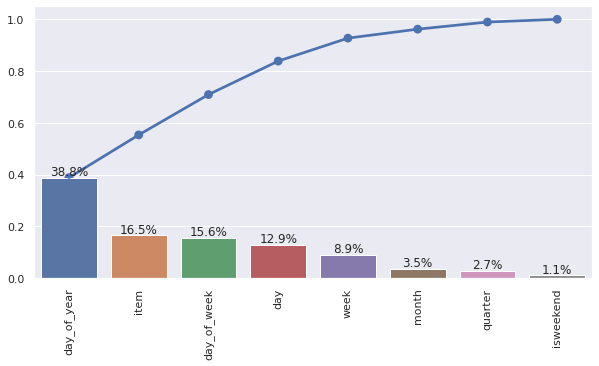

In [58]:
def plot_feature_importance(model):
    importances = model.feature_importances_
    feature_names = model.feature_names_in_
    def sort_key(x): return importances[list(feature_names).index(x)]
    feature_names = sorted(feature_names, key=sort_key, reverse=True)
    importances = sorted(importances, reverse=True)

    sns.set(rc={'figure.figsize': (10, 5)})
    ax = sns.barplot(x=feature_names, y=importances, )
    patches = ax.patches
    for i in range(len(patches)):
        x = patches[i].get_x() + patches[i].get_width()/2
        y = patches[i].get_height()+0.01
        ax.annotate('{:.1f}%'.format(importances[i]*100), (x, y), ha='center')
    plt.xticks(rotation=90)
    sns.pointplot(x=feature_names, y=np.cumsum(importances), )

plot_feature_importance(rf_model)

    Now we can put all our 4 models together to make the hybrid model

Text(0.5, 1.0, 'Sample Fourier item: 46')

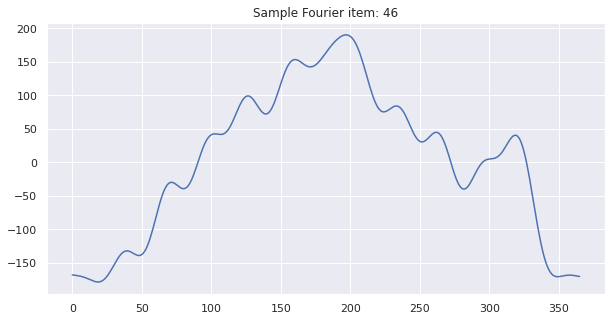

In [59]:
item_random = np.random.choice(df_original['item'].unique(),1)[0]
sns.lineplot(data=fft_models[item_random]).set_title(f"Sample Fourier item: {item_random}")


Text(0.5, 1.0, 'Sample Polynomial item: 16')

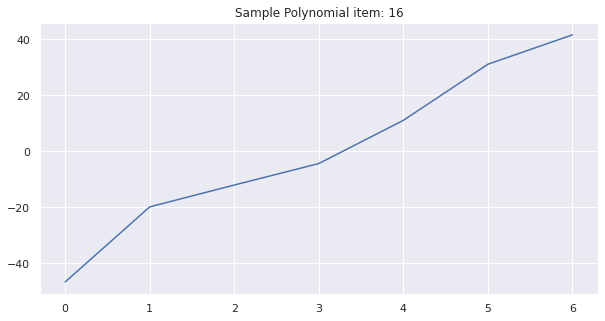

In [60]:
item_random = np.random.choice(df_original['item'].unique(),1)[0]
sns.lineplot(data=polynomial_models[1]).set_title(f"Sample Polynomial item: {item_random}")


    Regression model is in variable reg_poly

    Let us test our model for a random date range and item

In [61]:
predict_df = pd.DataFrame(index = pd.date_range(start='10-1-2017', periods=700))
predict_df.index.name = 'date'
item_to_predict = np.random.choice(df_original['item'].unique(),1)[0]
# item_to_predict = 1
predict_df['item'] = item_to_predict
predict_df.head(3)

,item
date,
2017-10-01,2
2017-10-02,2
2017-10-03,2


    Add features

In [62]:
def add_features(df_):
    df_["day"] = df_.index.day
    df_["day_of_week"] = df_.index.day_of_week
    df_["day_of_year"] = df_.index.day_of_year
    df_["isweekend"] = np.int0(df_.index.weekday > 4)
    df_["week"] =df_.index.week
    df_["month"] = df_.index.month
    df_["quarter"] = df_.index.quarter
    return df_

    Run models in reverse order

In [63]:
def run_models(df_: pd.DataFrame):
    cols_fit_order = ["item", "day_of_year", "day",
                      "day_of_week", "isweekend", "week", "month", "quarter"]
    df_ = df_[cols_fit_order]
    items = df_['item'].unique().tolist()
    for item in items:
        mask = df_['item'] == item
        #   Random Forest
        df_.loc[mask, 'sales'] = rf_model.predict(df_.loc[mask])
        #   Polynomial
        df_.loc[mask, "date_id"] = (df_.index-pivot_date).days
        df_.loc[mask, "sales"] = df_.loc[mask, "sales"] + \
            polynomial_models[item, df_.loc[mask, "day_of_week"]]
        #   Fourier Transform
        df_.loc[mask, "sales"] = df_.loc[mask, "sales"] + \
            fft_models[item, df_.loc[mask, "day_of_year"]-1]
        #   Linear Regression
        df_.loc[mask, "sales"] = df_.loc[mask, "sales"] + \
            reg_models[item](df_.loc[mask, "date_id"])

    return df_


In [ ]:
predict_df = add_features(predict_df)


In [ ]:

predict_df = run_models(predict_df)

y_pred = predict_df['sales']
y_pred.head(3)

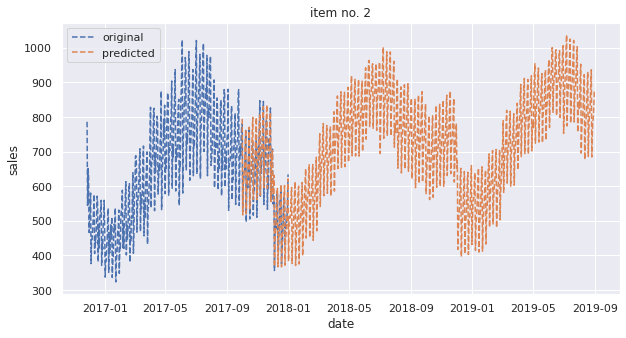

In [66]:
# sns.lineplot(data=y_pred)
df_1 = df_original.groupby(["date", "item"]).sum().reset_index()
df_1.drop("store", axis=1, inplace=True)
df_1.set_index('date', inplace=True)
data = df_1[df_1['item']
            == item_to_predict]['sales'].iloc[-400:]
sns.lineplot(data=data, linestyle='--', label='original').set_title(f"item no. {item_to_predict}")
sns.lineplot(data=y_pred,linestyle='--',  label='predicted')
plt.legend()


    We have successfully modeled the time series using our hybrid model